# Курсовая работа №1: анализ ЭКГ-сигнала 6 методами #

## Импортирование библиотек ##

In [44]:
# библиотеки для работы с матрицами и графиками
import numpy as np
import matplotlib.pyplot as plt

# автокорреляционный анализ
from statsmodels.tsa.stattools import acf

# импорт линейной регрессии
from sklearn.linear_model import LinearRegression

# библиотека для анализа ЭКГ и статистические методы анализа
from ecgdetectors import Detectors
from hrv import HRV

# библиотеки для фурье анализа
from scipy import signal
from scipy.fft import rfft, rfftfreq

#### Функции отрисовки графиков ####

In [45]:
# отрисовка части сигнала
def waveform_plot(x, y, title, x_label, y_label, name_save_file):
    plt.plot(x, y)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.savefig(name_save_file)
    plt.show()

## Подготовка данных ##

In [46]:
# имя файла
FILENAME = "1208.txt"
# загрузка сигнала
with open(FILENAME, "r") as file:
    ecg = np.loadtxt(file)

# количество отсчётов в файле
N = len(ecg)
# время записи сигнала в секундах
t = 2100
# частота дискретизации в Герцах
fs = N / t
# массив времени записи сигнала
time = np.linspace(0, 2100, N, endpoint=True)

In [47]:
print(f"Количество отсчётов в файле {N}")
print(f"Время записи сигнала в секундах {t}")
print(f"Частота дискретизации в Герцах {fs}")

Количество отсчётов в файле 525000
Время записи сигнала в секундах 2100
Частота дискретизации в Герцах 250.0


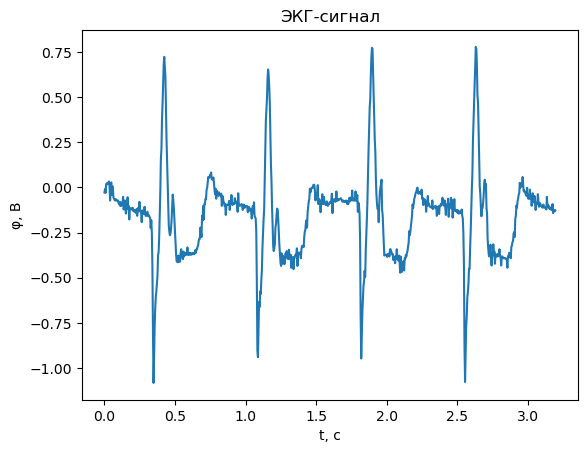

In [48]:
waveform_plot(x=time[:800], y=ecg[:800], title="ЭКГ-сигнал", x_label="t, с", y_label="φ, В", name_save_file="ecgsignal.png")

## Методы оценки ВСР ##
1. Статистический метод
2. Вариационный метод
3. Метод Фурье для ЭКГ сигнала
4. Скаттерограмма сигнала ЭКГ
5. Автокорреляционный анализ
6. Спектральный метод

## 1. Статистический метод ##

In [49]:
# использование детекторов пиков R-R из библиотеки
detectors = Detectors(sampling_frequency=fs)
# применение детектора Hamilton для поиска пиков R-R
r_peaks = detectors.pan_tompkins_detector(ecg)
# расчёт интервалов времени между пиками в мс
dt_r_peaks = np.array([time[r_peaks[i + 1]] - time[r_peaks[i]] for i in range(len(r_peaks) - 1)]) * 1000

In [50]:
hrv = HRV(fs)
sdnn = hrv.SDNN(r_peaks)
m = round(np.mean(dt_r_peaks))

print("Среднее значение времени между интервалами R-R, M =", m, "мс")
print("ЧСС =", round(np.average(hrv.HR(r_peaks))), "уд./мин.")
print("SDNN =", round(sdnn), "мс")
print("RMSSD =", round(hrv.RMSSD(r_peaks)), "мс")
print("NN50 =", hrv.NN50(r_peaks))
print("pNN50 =", round(100 * hrv.pNN50(r_peaks)), "%")
print("CV =", round(sdnn / m * 100), "%")

Среднее значение времени между интервалами R-R, M = 735 мс
ЧСС = 82 уд./мин.
SDNN = 37 мс
RMSSD = 63 мс
NN50 = 1257
pNN50 = 44 %
CV = 5 %


## 2. Вариационный метод ##

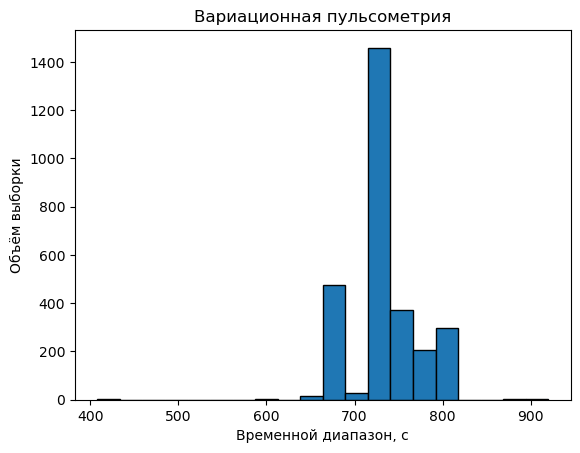

In [51]:
n = int(np.round((np.max(dt_r_peaks) - np.min(dt_r_peaks)) / 50)) + 10
stack = plt.hist(dt_r_peaks, bins=n, edgecolor = 'black')
plt.title("Вариационная пульсометрия")
plt.xlabel("Временной диапазон, с")
plt.ylabel("Объём выборки")
plt.savefig("Pulsometr.png")
plt.show()

In [52]:
NN = dt_r_peaks / 1000
n = np.uint8((np.amax(NN) - np.amin(NN)) * 1000 / 50)
am = np.histogram(NN, bins=n)[0]
m = np.array([i for i in np.histogram(NN, bins=n - 1)[1]])
am = am / np.sum(am) * 100
AM0, Nmax = np.amax(am), np.argmax(am)
M0 = m[Nmax]
m_vr = np.array([m[i] if am[i] > 3 else 0 for i in range(len(am))])
m_vr = m_vr[m_vr != 0]
VR = np.amax(m_vr) - np.amin(m_vr)
BPM_var = 60 / M0
IN = AM0 / (2 * M0 * VR)
IVR = AM0 / VR
VPR = 1 / (M0 * VR)
PAPR = AM0 / M0

print(f'M0 = {int(M0 * 1000)} мс')
print(f'ЧСС = {int(BPM_var)} уд./мин')
print(f'AM0 = {np.around(AM0, decimals=1)} %')
print(f'ВР = {int(VR * 1000)} мс')
print(f'ИН = {int(IN)}')
print(f'ИВР = {int(IVR)}')
print(f'ВПР = {int(VPR)}')
print(f'ПАПР = {int(PAPR)}')

M0 = 749 мс
ЧСС = 80 уд./мин
AM0 = 64.1 %
ВР = 113 мс
ИН = 376
ИВР = 563
ВПР = 11
ПАПР = 85


## 3. Метод Фурье анализа ##

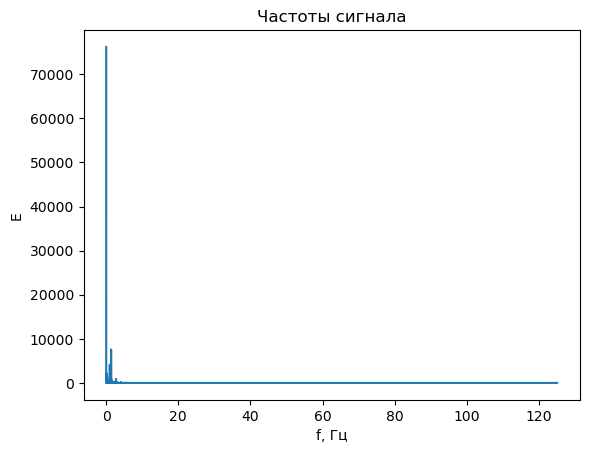

f = 1.359047619047619 Гц
ЧСС = 81.54285714285714 уд./мин.


In [53]:
# фильтрация сигнала
b, a = signal.butter(2, 0.01, "lowpass")
filt_ecg = signal.filtfilt(b, a, ecg)

# ДПФ сигнала
yf = rfft(filt_ecg)
xf = rfftfreq(N, 1 / fs)

# отрисовка преобразованного сигнала
waveform_plot(x=xf, y=np.abs(yf), title="Частоты сигнала", x_label="f, Гц", y_label="E", name_save_file="furie.png")

print(f"f = {xf[np.argmax(yf)]} Гц")
print(f"ЧСС = {60 * xf[np.argmax(yf)]} уд./мин.")

## 4. Скаттерограмма сигнала ВСР ##

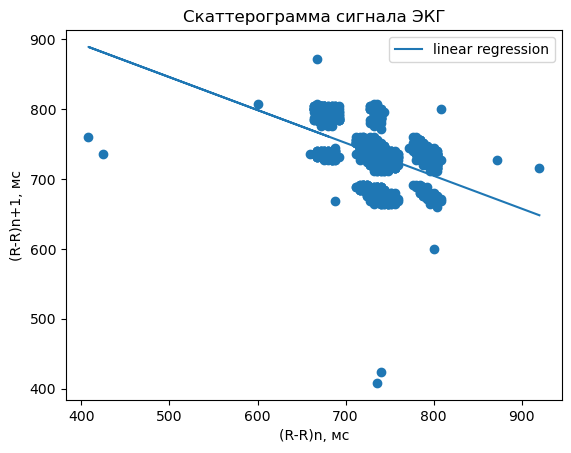

Праметры линейной регрессии:
a = -0.4709187927050266
b = 1081.4370736548115


In [54]:
NN = dt_r_peaks

RR_n = NN[0:len(NN) - 1]
RR_n1 = NN[1:len(NN)]

linear_reg = LinearRegression().fit(RR_n.reshape(-1, 1), RR_n1)
plt.scatter(RR_n, RR_n1)
plt.title("Скаттерограмма сигнала ЭКГ")
plt.ylabel("(R-R)n+1, мс")
plt.xlabel("(R-R)n, мс")
plt.plot(RR_n, linear_reg.predict(RR_n.reshape(-1, 1)), label="linear regression")
plt.legend()
plt.savefig("skater.png")
plt.show()
print("Праметры линейной регрессии:")
print(f"a = {linear_reg.coef_[0]}")
print(f"b = {linear_reg.intercept_}")

## 5. Автокорреляционный анализ ##

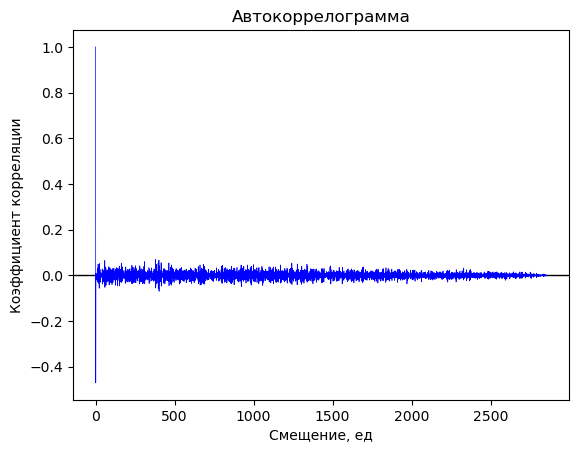

In [55]:
lag = len(dt_r_peaks)
acfs = acf(dt_r_peaks, nlags=lag)
acfs_ax = np.arange(0, len(acfs))

fig10, ax = plt.subplots()
ax.axhline(y=0, linewidth=1, color='black')
ax.plot(acfs_ax, acfs, linewidth=0.5, color='b')
ax.set(xlabel='Смещение, ед', ylabel='Коэффициент корреляции', title='Автокоррелограмма')
fig10.savefig("autocor.png")


## 6. Спектральный метод ##

In [56]:
yf *= np.conj(yf)

In [57]:
HF_dots = np.array([yf[i] if 0.15 <= xf[i] <= 0.4 else 0 for i in range(len(xf))])
LF_dots = np.array([yf[i] if 0.04 <= xf[i] <= 0.15 else 0 for i in range(len(xf))])
VLF_dots = np.array([yf[i] if 0.003 <= xf[i] <= 0.04 else 0 for i in range(len(xf))])

In [58]:
HF_ind = np.array([i if 0.15 <= xf[i] <= 0.4 else 0 for i in range(len(xf))])
HF_ind = HF_ind[HF_ind != 0]
LF_ind = np.array([i if 0.04 <= xf[i] <= 0.15 else 0 for i in range(len(xf))])
LF_ind = LF_ind[LF_ind != 0]
VLF_ind = np.array([i if 0.003 <= xf[i] <= 0.04 else 0 for i in range(len(xf))])
VLF_ind = VLF_ind[VLF_ind != 0]

In [59]:
# мощность каждого диапазона частот
HF = 1 / np.sum(HF_dots)
LF = 1 / np.sum(LF_dots)
VLF = 1 / np.sum(VLF_dots)

# суммарная мощность
TP = HF + LF + VLF

# процентное соотношение мощности каждого дипазона к общей мощности
HFn = np.uint8(HF / TP * 100)
LFn = np.uint8(LF / TP * 100)
VLFn = np.uint8(VLF / TP * 100)

LFHF = np.around(LF / HF, decimals=1)  # индекс вагосимпатического взаимодействия
IC = np.around((HF + LF) / VLF, decimals=1)  # индекс централизации

# построение спектрограммы
f_half_spect = np.array([xf[i] if 0 <= xf[i] <= 1 else 0 for i in range(len(xf))])
f_half_spect = f_half_spect[f_half_spect != 0]
t_half_spect = 1 / f_half_spect

/tmp/ipykernel_5123/2900493580.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  HFn = np.uint8(HF / TP * 100)
/tmp/ipykernel_5123/2900493580.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  LFn = np.uint8(LF / TP * 100)
/tmp/ipykernel_5123/2900493580.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  VLFn = np.uint8(VLF / TP * 100)


/home/andrey/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


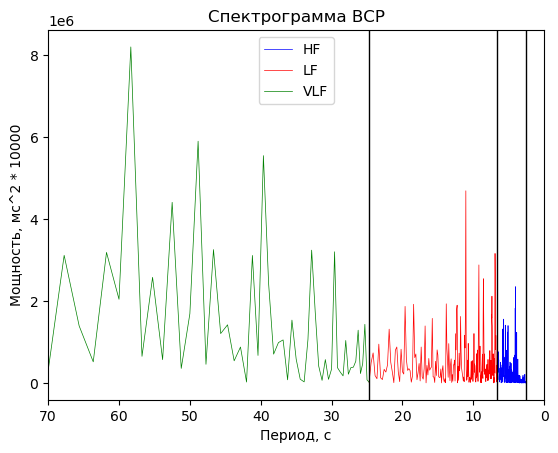

In [60]:
fig5, ax = plt.subplots()
ax.set_xlim(70, 0)
ax.plot(t_half_spect[HF_ind], yf[HF_ind], linewidth=0.5, color='b', label='HF')
ax.axvline(t_half_spect[np.amax(HF_ind)], color='black', linewidth=1)
ax.plot(t_half_spect[LF_ind], yf[LF_ind], linewidth=0.5, color='r', label='LF')
ax.axvline(t_half_spect[np.amax(LF_ind)], color='black', linewidth=1)
ax.plot(t_half_spect[VLF_ind], yf[VLF_ind], linewidth=0.5, color='g', label='VLF')
ax.axvline(t_half_spect[np.amax(VLF_ind)], color='black', linewidth=1)
ax.legend()
ax.set(xlabel='Период, с', ylabel='Мощность, мс^2 * 10000', title='Спектрограмма ВСР')
fig5.savefig("spektr.png")

In [61]:
print(f'HF = {HF} мс^2')
print(f'LF = {LF} мс^2')
print(f'VLF = {VLF} мс^2')
print(f'TP = {TP} мс^2')
print(f'HFn = {HFn} %')
print(f'LFn = {LFn} %')
print(f'VLFn = {VLFn} %')
print(f'LF / HF = {LFHF}')
print(f'ИЦ = {IC}')

HF = (1.2669923162659951e-08+0j) мс^2
LF = (8.339639184646955e-09+0j) мс^2
VLF = (8.829533652184749e-09+0j) мс^2
TP = (2.983909599949166e-08+0j) мс^2
HFn = 42 %
LFn = 27 %
VLFn = 29 %
LF / HF = (0.7+0j)
ИЦ = (2.4+0j)
